In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from env import get_db_url

# Import acquire and prepare
import acquire
import wrangle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load currciculum access logs
df = acquire.get_access_data()

In [3]:
df, df_staff, df_multicohort, df_unimputed, df_non_curriculum, df_outliers = wrangle.full_wrangle()

In [4]:
df.head()

,user_id,path,ip,cohort,unit,subunit,lesson,other,start_date,end_date,program_id,hour,program_type
accessed,,,,,,,,,,,,,
2018-01-26 09:56:02,1,java-ii,97.105.19.61,Hampton,java-ii,,,,2015-09-22,2016-02-06,1,9,Web Development
2018-01-26 09:56:05,1,java-ii/object-oriented-programming,97.105.19.61,Hampton,java-ii,,object-oriented-programming,,2015-09-22,2016-02-06,1,9,Web Development
2018-01-26 09:56:06,1,slides/object_oriented_programming,97.105.19.61,Hampton,slides,,object_oriented_programming,,2015-09-22,2016-02-06,1,9,Web Development
2018-01-26 09:56:24,2,javascript-i/conditionals,97.105.19.61,Teddy,javascript-i,,conditionals,,2018-01-08,2018-05-17,2,9,Web Development
2018-01-26 09:56:41,2,javascript-i/loops,97.105.19.61,Teddy,javascript-i,,loops,,2018-01-08,2018-05-17,2,9,Web Development


In [5]:
df.program_type.value_counts()

Web Development    451039
Data Science        58370
Name: program_type, dtype: int64

In [6]:
# Create seperate dataframes for Web Development and Data Science programs
wd = df[df.program_type != 'Data Science']
ds = df[df.program_type == 'Data Science']

# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [7]:
# Pages with most traffic
pd.DataFrame(wd.path.value_counts().head())

,path
javascript-i,12740
java-iii,9509
html-css,9290
java-ii,8875
spring,8622


In [8]:
# Pages with most traffic
pd.DataFrame(ds.path.value_counts().head())

,path
classification/overview,1310
1-fundamentals/1.1-intro-to-data-science,1270
classification/scale_features_or_not.svg,1138
sql/mysql-overview,1008
fundamentals/intro-to-data-science,946


# 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

Text(0, 0.5, 'Number of Page Visits')

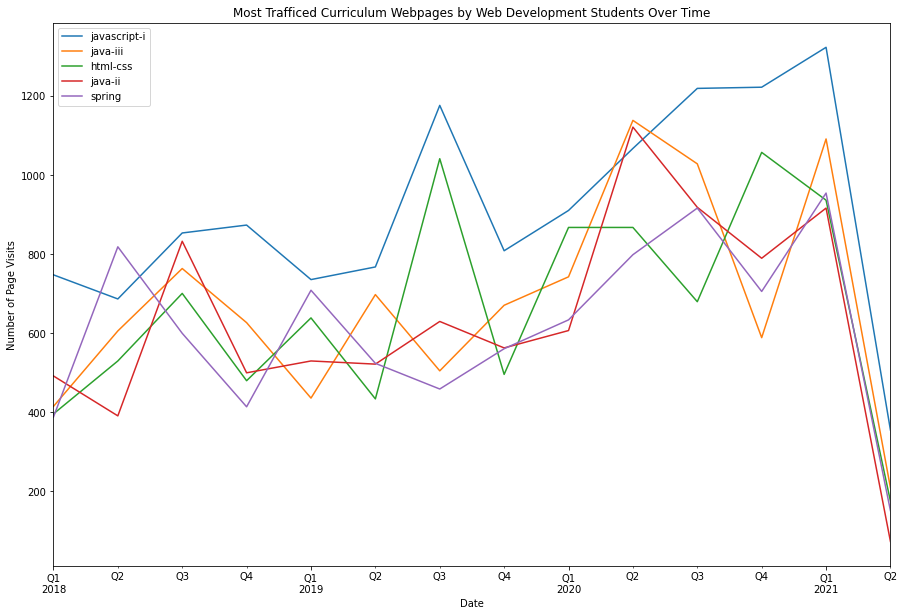

In [9]:
plt.figure(figsize=(15,10))
wd[wd.path == 'javascript-i'].path.resample('Q').count().plot()
wd[wd.path == 'java-iii'].path.resample('Q').count().plot()
wd[wd.path == 'html-css'].path.resample('Q').count().plot()
wd[wd.path == 'java-ii'].path.resample('Q').count().plot()
wd[wd.path == 'spring'].path.resample('Q').count().plot()
plt.legend(labels = ['javascript-i', 'java-iii', 'html-css', 'java-ii', 'spring'])
plt.title('Most Trafficed Curriculum Webpages by Web Development Students Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Page Visits')

# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [10]:
# Filter dataframe for the time when student were 'active' for each program
active_wd = wd.loc[(wd.index >= wd.start_date) & (wd.index <= wd.end_date)]
active_ds = ds.loc[(ds.index >= ds.start_date) & (ds.index <= ds.end_date)]

In [11]:
# web dev users with lowest page count
hardly_access_wd = active_wd.groupby('user_id').size().sort_values().head()
hardly_access_wd

user_id
278     3
340    13
963    15
41     22
371    24
dtype: int64

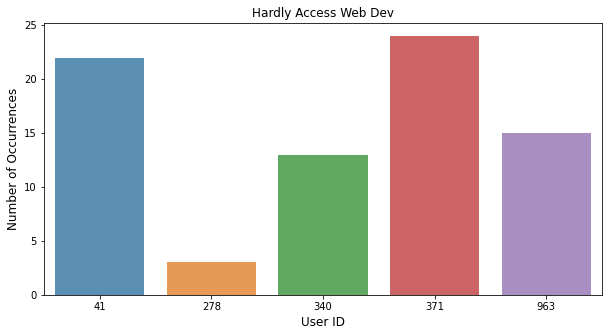

In [12]:

user_id_count  = active_wd.groupby('user_id').size().sort_values().head()
user_id_count = user_id_count[:5,]
plt.figure(figsize=(10,5))
sns.barplot(user_id_count.index, user_id_count.values, alpha=0.8)
plt.title('Hardly Access Web Dev')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('User ID', fontsize=12)
plt.show()

In [13]:
# data science users with lowest page count
hardly_access_ds = active_ds.groupby('user_id').size().sort_values().head()
hardly_access_ds

user_id
902    118
780    145
577    190
901    201
683    205
dtype: int64

# 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [14]:
# Requests allows you to send HTTP/1.1 requests extremely easily. There’s no need to manually add query 
# strings to your URLs, or to form-encode your PUT & POST data — but nowadays, just use the json method!

import requests

In [15]:
df_sus_users = df.copy()

ip_count = df_sus_users.ip.nunique()
ip_count

2560

In [16]:
#pd.set_option('display.max_rows', None)
#df_sus_users.groupby('ip').size().sort_values().unique()

In [17]:
df_sus_users.loc[df_sus_users['ip'] == '221.229.204.176']

,user_id,path,ip,cohort,unit,subunit,lesson,other,start_date,end_date,program_id,hour,program_type
accessed,,,,,,,,,,,,,


In [18]:
import ipapi

In [19]:
ipapi.location(ip='221.229.204.176')

{'ip': '221.229.204.176',
 'version': 'IPv4',
 'city': 'Tongshan',
 'region': 'Henan',
 'region_code': 'HA',
 'country': 'CN',
 'country_name': 'China',
 'country_code': 'CN',
 'country_code_iso3': 'CHN',
 'country_capital': 'Beijing',
 'country_tld': '.cn',
 'continent_code': 'AS',
 'in_eu': False,
 'postal': None,
 'latitude': 32.7705,
 'longitude': 113.561,
 'timezone': 'Asia/Shanghai',
 'utc_offset': '+0800',
 'country_calling_code': '+86',
 'currency': 'CNY',
 'currency_name': 'Yuan Renminbi',
 'languages': 'zh-CN,yue,wuu,dta,ug,za',
 'country_area': 9596960.0,
 'country_population': 1392730000,
 'asn': 'AS4134',
 'org': 'Chinanet'}

In [20]:
#pd.set_option('display.max_columns', None)

import json

# IP address to test
ip_address = '24.242.183.202'

# URL to send the request to
request_url = 'https://geolocation-db.com/jsonp/' + ip_address
# Send request and decode the result
response = requests.get(request_url)
result = response.content.decode()
# Clean the returned string so it just contains the dictionary data for the IP address
result = result.split("(")[1].strip(")")
# Convert this data into a dictionary
result  = json.loads(result)
print(result)

{'country_code': 'US', 'country_name': 'United States', 'city': 'Killeen', 'postal': '76541', 'latitude': 31.1164, 'longitude': -97.7278, 'IPv4': '24.242.183.202', 'state': 'Texas'}


In [21]:
import ipaddress 

def validate_ip_address(df_sus_users):
    try:
        ip = ipaddress.ip_address(df_sus_users.ip)
        print("IP address {} is valid. The object returned is {}".format(df_sus_users, ip))
    except ValueError:
        print("IP address {} is not valid".format(df_sus_users))

In [22]:
#validate_ip_address(df_sus_users)

# 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [23]:
# Number of cross-accessed pages in the last year
df[2019:].groupby('path').size().index.isin(df[2019:].groupby('path').size().index).sum()

1484

In [24]:
# Unique pages in a list of WD and DS
wd_users = list(wd.user_id.unique())
ds_users = list(ds.user_id.unique())

In [25]:
# All cross accessed observations
cross_observations = df[2019:][(df[2019:].path.isin(wd[2019:].path)) & (df[2019:].path.isin(ds[2020:].path))]
cross_observations.head()

,user_id,path,ip,cohort,unit,subunit,lesson,other,start_date,end_date,program_id,hour,program_type
accessed,,,,,,,,,,,,,
2018-01-31 13:55:18,33,mysql,97.105.19.61,Sequoia,mysql,,,,2017-09-27,2018-02-15,2,13,Web Development
2018-01-31 13:56:50,16,html-css/forms,97.105.19.61,Sequoia,html-css,,forms,,2017-09-27,2018-02-15,2,13,Web Development
2018-01-31 14:04:42,33,mysql,97.105.19.61,Sequoia,mysql,,,,2017-09-27,2018-02-15,2,14,Web Development
2018-01-31 14:19:32,33,mysql,97.105.19.61,Sequoia,mysql,,,,2017-09-27,2018-02-15,2,14,Web Development
2018-01-31 14:32:16,11,javascript-i,97.105.19.61,Arches,javascript-i,,,,2014-02-04,2014-04-22,1,14,Web Development


In [27]:
# Cohorts who cross accessed
cross_observations.cohort.value_counts()

Ceres         6384
Voyageurs     6344
Apex          6056
Zion          6041
Jupiter       5758
Xanadu        5662
Deimos        5630
Fortuna       5208
Teddy         4874
Hyperion      4722
Ganymede      4560
Bayes         4553
Kalypso       4003
Darden        3928
Andromeda     3904
Betelgeuse    3845
Curie         3581
Bash          3427
Europa        3408
Wrangell      3278
Ulysses       3170
Yosemite      2871
Lassen        2512
Marco         2307
Luna          2075
Sequoia       1587
Arches        1190
Easley        1021
Florence       787
Pinnacles      507
Neptune        360
Hampton        335
Niagara        230
Kings          147
Olympic        115
Quincy          99
Ike             90
Mammoth         75
Oberon          53
Franklin        20
Glacier         12
Joshua           8
Badlands         6
Name: cohort, dtype: int64

# 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [28]:
# Filter dataframes for data points only after graduation date
postgrad_access_wd = wd[(wd.index > wd.end_date)]
postgrad_access_ds = ds[(ds.index > ds.end_date)]

In [29]:
postgrad_access_wd.path.value_counts().head()

javascript-i    2432
spring          2313
html-css        1933
java-i          1691
java-ii         1686
Name: path, dtype: int64

<AxesSubplot:>

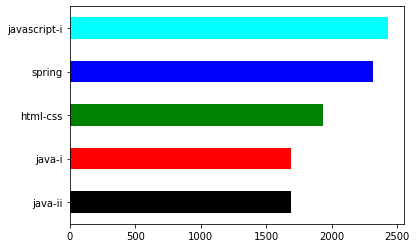

In [135]:
postgrad_access_wd.path.value_counts().head().sort_values(ascending=True).plot(
    kind='barh', color=['black', 'red', 'green', 'blue', 'cyan'])


In [31]:
postgrad_access_ds.path.value_counts().head()

classification/overview                     220
sql/mysql-overview                          210
classification/scale_features_or_not.svg    174
fundamentals/intro-to-data-science          138
anomaly-detection/overview                  127
Name: path, dtype: int64

<AxesSubplot:>

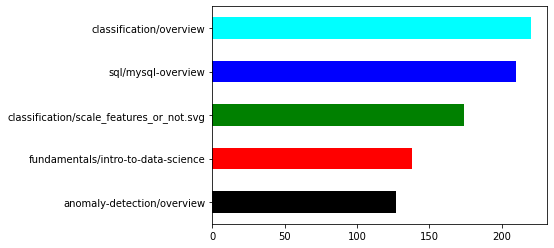

In [134]:
postgrad_access_ds.path.value_counts().head().sort_values(ascending=True).plot(kind='barh', 
                                                                               color=['black', 'red', 'green', 'blue', 'cyan'])

Text(0.5, 1.0, 'Topics referenced after grad')

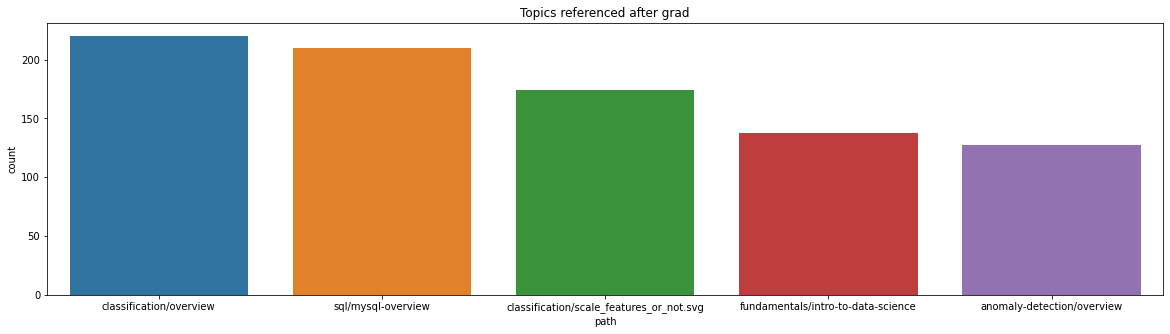

In [133]:
plt.figure(figsize=(20,5))
sns.countplot(x=postgrad_access_ds.path, 
              order=postgrad_access_ds.path.value_counts().iloc[:5].index).set_title("Topics referenced after grad")

Text(0.5, 1.0, 'Topics Referenced after Graduation')

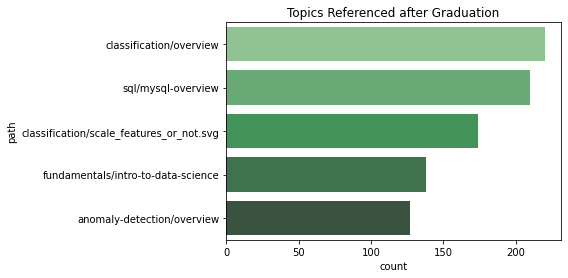

In [132]:
sns.countplot(y="path", data=postgrad_access_ds, palette="Greens_d", 
              order=postgrad_access_ds.path.value_counts().iloc[:5].index)
plt.title("Topics Referenced after Graduation")

<AxesSubplot:title={'center':'Most Topics Referenced after Graduation'}, xlabel='count', ylabel='path'>

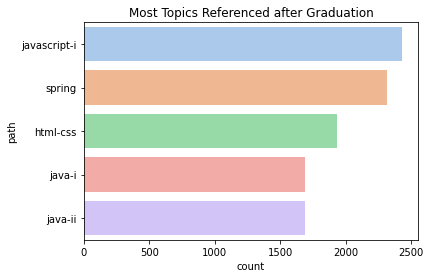

In [131]:
plt.title("Most Topics Referenced after Graduation")
sns.countplot(y="path",data=postgrad_access_wd, palette="pastel", 
              order=postgrad_access_wd.path.value_counts().iloc[:5].index)

# 7. Which lessons are least accessed?

In [32]:
wd.path.value_counts().tail()

examples/css/..%5c    1
115                   1
133                   1
131                   1
javascript/loops      1
Name: path, dtype: int64

In [33]:
ds.path.value_counts().tail()

itc%20-%20ml                 1
itc-ml                       1
java-i/console-io            1
clustering/dbscan            1
2.1-spreadsheets-overview    1
Name: path, dtype: int64